In [53]:
from train import valid, set_seed
from apex import amp
import torch
import argparse
from addict import Dict
import logging
import matplotlib.pyplot as plt
import logging
from utils.data_utils import get_loader
from models.modeling import VisionTransformer, CONFIGS
import numpy as np
from torch.utils.data import Subset
!export CUDA_VISIBLE_DEVICES=2
import torch.nn.functional as F

In [54]:
from utils.construct_tff import construct_real_tff, construct_tight_frames

In [55]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [56]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000


In [57]:
args = Dict()
args.model_type = 'ViT-B_16'
args.dataset = 'inet1k_cats'
args.img_size = 224
args.pretrained_dir = 'checkpoint/ViT-B_16-224.npz'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device
args.local_rank = -1
args.train_batch_size = 16
args.eval_batch_size = 16

# args.dataset = 'inet1k_cats'
# args.dataset_dir = 'data/inet1k_classes/cats'
# ckpt_path = 'output/inet1k_cats-2023-10-02-22-19-15/inet1k_cats_final_ckpt.bin' 
args.dataset = 'inet1k_birds'
args.dataset_dir = 'data/inet1k_classes/birds'
ckpt_path = 'output/inet1k_birds-2023-10-17-03-04-30/inet1k_birds_final_ckpt.bin'
# args.dataset = 'inet1k_dogs'
# args.dataset_dir = 'data/inet1k_classes/dogs'
# ckpt_path = 'output/inet1k_dogs-2023-09-24-21-00-17/inet1k_dogs_final_ckpt.bin'
# args.dataset = 'inet1k_snakes'
# args.dataset_dir = 'data/inet1k_classes/snakes'
# ckpt_path = 'output/inet1k_snakes-2023-10-02-22-28-06/inet1k_snakes_final_ckpt.bin'
# args.dataset = 'inet1k_trucks'
# args.dataset_dir = 'data/inet1k_classes/trucks'
# ckpt_path = 'output/inet1k_trucks-2023-09-24-20-47-28/inet1k_trucks_final_ckpt.bin'


In [58]:
# Prepare model
config = CONFIGS[args.model_type]

if args.dataset == "cifar10":
    num_classes = 10
elif args.dataset == "cifar100":
    num_classes = 100
elif 'inet' in args.dataset:
    num_classes = 10

model = VisionTransformer(config, args.img_size, zero_head=False, num_classes=num_classes)
# model.load_from(np.load(args.pretrained_dir))
model.load_state_dict(torch.load(ckpt_path))
model.to(args.device)
model.eval()
num_params = count_parameters(model)

logger.info("{}".format(config))
logger.info("Training parameters %s", args)
logger.info("Total Parameter: \t%2.1fM" % num_params)



2023-10-27 13:33:28,760 - __main__ - INFO - classifier: token
hidden_size: 768
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

2023-10-27 13:33:28,762 - __main__ - INFO - Training parameters {'model_type': 'ViT-B_16', 'dataset': 'inet1k_birds', 'img_size': 224, 'pretrained_dir': 'checkpoint/ViT-B_16-224.npz', 'device': device(type='cuda'), 'local_rank': -1, 'train_batch_size': 16, 'eval_batch_size': 16, 'dataset_dir': 'data/inet1k_classes/birds'}
2023-10-27 13:33:28,762 - __main__ - INFO - Total Parameter: 	85.8M


In [59]:
train_loader, test_loader = get_loader(args)
classes = train_loader.dataset.dataset.classes


In [60]:
val_acc = valid(args, model, writer=None, test_loader=test_loader, global_step=0)
print(val_acc)

2023-10-27 13:33:29,955 - train - INFO - ***** Running Validation *****
2023-10-27 13:33:29,956 - train - INFO -   Num steps = 155
2023-10-27 13:33:29,957 - train - INFO -   Batch size = 16
Validating... (loss=0.05767): 100%|| 155/155 [00:08<00:00, 18.48it/s]
2023-10-27 13:33:38,350 - train - INFO - 

2023-10-27 13:33:38,351 - train - INFO - Validation Results
2023-10-27 13:33:38,352 - train - INFO - Global Steps: 0
2023-10-27 13:33:38,352 - train - INFO - Valid Loss: 0.01231
2023-10-27 13:33:38,353 - train - INFO - Valid Accuracy: 0.99718


0.9971762807583703


In [61]:
def quantize_qfna(x, scale, zero, maxq):
    q = torch.clamp(torch.round(x / scale) + zero, 0, maxq)
    return scale * (q - zero)


In [52]:
print(args.device)

cuda


In [51]:
# This is with the Weiner Filter based estimation
# redundancies = [1,2,3,4,5]
# bws = [2,3,4,8,16,32]
redundancies = [1,2,3,4,5]
bws = [2,3,4,8]

val_accs = {}
compressions = {}
for redundancy in redundancies:
    print(f'{redundancy = }')
    # set tff related params
    tffs = {}
    k_attn = int(96 * redundancy)
    l_attn = 8
    n_attn = 768
    tffs[n_attn] = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)

    k_mlp = int(384 * redundancy)
    l_mlp = 8
    n_mlp = 3072
    tffs[n_mlp] = construct_real_tff(k_mlp, l_mlp // 2, n_mlp // 2).to(args.device)

    val_accs_r = []
    compressions_r = []
    for bw in bws:
        print(f'{bw = }')
        model = VisionTransformer(config, args.img_size, zero_head=False, num_classes=num_classes)
        model.load_state_dict(torch.load(ckpt_path))
        model.eval()
        model.to(args.device)

        # set bit width related params
        maxq = torch.tensor(2**bw - 1)
        for name, param in model.named_parameters():
            if 'attn' in name or 'ffn.' in name:
                wmat = param.data
                if 'bias' in name:
                    print(name)
                    wmat = wmat.view(-1,1)
                tff_n = wmat.shape[0]
                projs = torch.matmul(tffs[tff_n], wmat)
                num_frames = projs.shape[0]*projs.shape[1]
                # quantize the projs
                xmax = projs.max()
                xmin = projs.min()
                scale = (xmax - xmin) / maxq
                zero = torch.round(-xmin / scale)
                projs_qntzd = quantize_qfna(projs, scale, zero, maxq) 
                # compute the weiner filter
                z = projs_qntzd.view(num_frames, -1)
                Rxz = wmat @ z.T
                Rzz = z @ z.T
                wmat_est = Rxz @ torch.linalg.pinv(Rzz) @ z
                param.data = wmat_est.squeeze()
                # param.data = (tffs.view(-1,n_attn).T @ projs_qntzd.view(k_attn*l_attn, -1)).squeeze()

        val_acc = valid(args, model, writer=None, test_loader=test_loader, global_step=0)
        val_accs_r.append(val_acc)

        compression = 32/(redundancy*bw)
        compressions_r.append(compression)
    val_accs[redundancy] = val_accs_r
    compressions[redundancy] = compressions_r

redundancy = 1
bw = 2
transformer.encoder.layer.0.ffn.fc1.bias
transformer.encoder.layer.0.ffn.fc2.bias
transformer.encoder.layer.0.attn.query.bias
transformer.encoder.layer.0.attn.key.bias
transformer.encoder.layer.0.attn.value.bias
transformer.encoder.layer.0.attn.out.bias
transformer.encoder.layer.1.ffn.fc1.bias
transformer.encoder.layer.1.ffn.fc2.bias
transformer.encoder.layer.1.attn.query.bias
transformer.encoder.layer.1.attn.key.bias
transformer.encoder.layer.1.attn.value.bias
transformer.encoder.layer.1.attn.out.bias
transformer.encoder.layer.2.ffn.fc1.bias
transformer.encoder.layer.2.ffn.fc2.bias
transformer.encoder.layer.2.attn.query.bias
transformer.encoder.layer.2.attn.key.bias
transformer.encoder.layer.2.attn.value.bias
transformer.encoder.layer.2.attn.out.bias
transformer.encoder.layer.3.ffn.fc1.bias
transformer.encoder.layer.3.ffn.fc2.bias
transformer.encoder.layer.3.attn.query.bias
transformer.encoder.layer.3.attn.key.bias
transformer.encoder.layer.3.attn.value.bias
tran

2023-10-26 15:33:08,557 - train - INFO - ***** Running Validation *****
2023-10-26 15:33:08,558 - train - INFO -   Num steps = 155
2023-10-26 15:33:08,559 - train - INFO -   Batch size = 16


transformer.encoder.layer.11.attn.value.bias
transformer.encoder.layer.11.attn.out.bias


Validating... (loss=2.51190): 100%|| 155/155 [00:08<00:00, 18.61it/s]
2023-10-26 15:33:16,891 - train - INFO - 

2023-10-26 15:33:16,892 - train - INFO - Validation Results
2023-10-26 15:33:16,893 - train - INFO - Global Steps: 0
2023-10-26 15:33:16,893 - train - INFO - Valid Loss: 2.64504
2023-10-26 15:33:16,894 - train - INFO - Valid Accuracy: 0.07705


bw = 3
transformer.encoder.layer.0.ffn.fc1.bias
transformer.encoder.layer.0.ffn.fc2.bias
transformer.encoder.layer.0.attn.query.bias
transformer.encoder.layer.0.attn.key.bias
transformer.encoder.layer.0.attn.value.bias
transformer.encoder.layer.0.attn.out.bias
transformer.encoder.layer.1.ffn.fc1.bias
transformer.encoder.layer.1.ffn.fc2.bias
transformer.encoder.layer.1.attn.query.bias
transformer.encoder.layer.1.attn.key.bias
transformer.encoder.layer.1.attn.value.bias
transformer.encoder.layer.1.attn.out.bias
transformer.encoder.layer.2.ffn.fc1.bias
transformer.encoder.layer.2.ffn.fc2.bias
transformer.encoder.layer.2.attn.query.bias
transformer.encoder.layer.2.attn.key.bias
transformer.encoder.layer.2.attn.value.bias
transformer.encoder.layer.2.attn.out.bias
transformer.encoder.layer.3.ffn.fc1.bias
transformer.encoder.layer.3.ffn.fc2.bias
transformer.encoder.layer.3.attn.query.bias
transformer.encoder.layer.3.attn.key.bias
transformer.encoder.layer.3.attn.value.bias
transformer.encoder

2023-10-26 15:33:56,596 - train - INFO - ***** Running Validation *****
2023-10-26 15:33:56,597 - train - INFO -   Num steps = 155
2023-10-26 15:33:56,597 - train - INFO -   Batch size = 16


transformer.encoder.layer.11.attn.key.bias
transformer.encoder.layer.11.attn.value.bias
transformer.encoder.layer.11.attn.out.bias


Validating... (loss=0.03964): 100%|| 155/155 [00:08<00:00, 18.02it/s]
2023-10-26 15:34:05,204 - train - INFO - 

2023-10-26 15:34:05,205 - train - INFO - Validation Results
2023-10-26 15:34:05,206 - train - INFO - Global Steps: 0
2023-10-26 15:34:05,207 - train - INFO - Valid Loss: 0.06035
2023-10-26 15:34:05,207 - train - INFO - Valid Accuracy: 0.98386


bw = 4
transformer.encoder.layer.0.ffn.fc1.bias
transformer.encoder.layer.0.ffn.fc2.bias
transformer.encoder.layer.0.attn.query.bias
transformer.encoder.layer.0.attn.key.bias
transformer.encoder.layer.0.attn.value.bias
transformer.encoder.layer.0.attn.out.bias
transformer.encoder.layer.1.ffn.fc1.bias
transformer.encoder.layer.1.ffn.fc2.bias
transformer.encoder.layer.1.attn.query.bias
transformer.encoder.layer.1.attn.key.bias
transformer.encoder.layer.1.attn.value.bias
transformer.encoder.layer.1.attn.out.bias
transformer.encoder.layer.2.ffn.fc1.bias
transformer.encoder.layer.2.ffn.fc2.bias
transformer.encoder.layer.2.attn.query.bias
transformer.encoder.layer.2.attn.key.bias
transformer.encoder.layer.2.attn.value.bias
transformer.encoder.layer.2.attn.out.bias
transformer.encoder.layer.3.ffn.fc1.bias
transformer.encoder.layer.3.ffn.fc2.bias
transformer.encoder.layer.3.attn.query.bias
transformer.encoder.layer.3.attn.key.bias
transformer.encoder.layer.3.attn.value.bias
transformer.encoder

2023-10-26 15:34:48,037 - train - INFO - ***** Running Validation *****
2023-10-26 15:34:48,038 - train - INFO -   Num steps = 155
2023-10-26 15:34:48,038 - train - INFO -   Batch size = 16


transformer.encoder.layer.11.attn.out.bias


Validating... (loss=0.01968): 100%|| 155/155 [00:08<00:00, 18.36it/s]
2023-10-26 15:34:56,487 - train - INFO - 

2023-10-26 15:34:56,488 - train - INFO - Validation Results
2023-10-26 15:34:56,488 - train - INFO - Global Steps: 0
2023-10-26 15:34:56,489 - train - INFO - Valid Loss: 0.01996
2023-10-26 15:34:56,489 - train - INFO - Valid Accuracy: 0.99314


bw = 8
transformer.encoder.layer.0.ffn.fc1.bias
transformer.encoder.layer.0.ffn.fc2.bias
transformer.encoder.layer.0.attn.query.bias
transformer.encoder.layer.0.attn.key.bias
transformer.encoder.layer.0.attn.value.bias
transformer.encoder.layer.0.attn.out.bias
transformer.encoder.layer.1.ffn.fc1.bias
transformer.encoder.layer.1.ffn.fc2.bias
transformer.encoder.layer.1.attn.query.bias
transformer.encoder.layer.1.attn.key.bias
transformer.encoder.layer.1.attn.value.bias
transformer.encoder.layer.1.attn.out.bias
transformer.encoder.layer.2.ffn.fc1.bias
transformer.encoder.layer.2.ffn.fc2.bias
transformer.encoder.layer.2.attn.query.bias
transformer.encoder.layer.2.attn.key.bias
transformer.encoder.layer.2.attn.value.bias
transformer.encoder.layer.2.attn.out.bias
transformer.encoder.layer.3.ffn.fc1.bias
transformer.encoder.layer.3.ffn.fc2.bias
transformer.encoder.layer.3.attn.query.bias
transformer.encoder.layer.3.attn.key.bias
transformer.encoder.layer.3.attn.value.bias
transformer.encoder

2023-10-26 15:35:41,878 - train - INFO - ***** Running Validation *****
2023-10-26 15:35:41,879 - train - INFO -   Num steps = 155
2023-10-26 15:35:41,879 - train - INFO -   Batch size = 16


transformer.encoder.layer.11.attn.value.bias
transformer.encoder.layer.11.attn.out.bias


Validating... (loss=0.00271): 100%|| 155/155 [00:08<00:00, 17.95it/s]
2023-10-26 15:35:50,520 - train - INFO - 

2023-10-26 15:35:50,521 - train - INFO - Validation Results
2023-10-26 15:35:50,521 - train - INFO - Global Steps: 0
2023-10-26 15:35:50,521 - train - INFO - Valid Loss: 0.01121
2023-10-26 15:35:50,521 - train - INFO - Valid Accuracy: 0.99758


redundancy = 2
bw = 2
transformer.encoder.layer.0.ffn.fc1.bias
transformer.encoder.layer.0.ffn.fc2.bias
transformer.encoder.layer.0.attn.query.bias
transformer.encoder.layer.0.attn.key.bias
transformer.encoder.layer.0.attn.value.bias
transformer.encoder.layer.0.attn.out.bias
transformer.encoder.layer.1.ffn.fc1.bias
transformer.encoder.layer.1.ffn.fc2.bias
transformer.encoder.layer.1.attn.query.bias
transformer.encoder.layer.1.attn.key.bias
transformer.encoder.layer.1.attn.value.bias
transformer.encoder.layer.1.attn.out.bias
transformer.encoder.layer.2.ffn.fc1.bias
transformer.encoder.layer.2.ffn.fc2.bias
transformer.encoder.layer.2.attn.query.bias
transformer.encoder.layer.2.attn.key.bias
transformer.encoder.layer.2.attn.value.bias
transformer.encoder.layer.2.attn.out.bias
transformer.encoder.layer.3.ffn.fc1.bias
transformer.encoder.layer.3.ffn.fc2.bias
transformer.encoder.layer.3.attn.query.bias
transformer.encoder.layer.3.attn.key.bias
transformer.encoder.layer.3.attn.value.bias
tran

2023-10-26 15:36:22,433 - train - INFO - ***** Running Validation *****
2023-10-26 15:36:22,434 - train - INFO -   Num steps = 155
2023-10-26 15:36:22,434 - train - INFO -   Batch size = 16


transformer.encoder.layer.11.attn.out.bias


Validating... (loss=2.77009): 100%|| 155/155 [00:08<00:00, 18.20it/s]
2023-10-26 15:36:30,954 - train - INFO - 

2023-10-26 15:36:30,955 - train - INFO - Validation Results
2023-10-26 15:36:30,955 - train - INFO - Global Steps: 0
2023-10-26 15:36:30,955 - train - INFO - Valid Loss: 2.95108
2023-10-26 15:36:30,956 - train - INFO - Valid Accuracy: 0.09318


bw = 3
transformer.encoder.layer.0.ffn.fc1.bias
transformer.encoder.layer.0.ffn.fc2.bias
transformer.encoder.layer.0.attn.query.bias
transformer.encoder.layer.0.attn.key.bias
transformer.encoder.layer.0.attn.value.bias
transformer.encoder.layer.0.attn.out.bias
transformer.encoder.layer.1.ffn.fc1.bias
transformer.encoder.layer.1.ffn.fc2.bias
transformer.encoder.layer.1.attn.query.bias
transformer.encoder.layer.1.attn.key.bias
transformer.encoder.layer.1.attn.value.bias
transformer.encoder.layer.1.attn.out.bias
transformer.encoder.layer.2.ffn.fc1.bias
transformer.encoder.layer.2.ffn.fc2.bias
transformer.encoder.layer.2.attn.query.bias
transformer.encoder.layer.2.attn.key.bias
transformer.encoder.layer.2.attn.value.bias
transformer.encoder.layer.2.attn.out.bias
transformer.encoder.layer.3.ffn.fc1.bias
transformer.encoder.layer.3.ffn.fc2.bias
transformer.encoder.layer.3.attn.query.bias
transformer.encoder.layer.3.attn.key.bias
transformer.encoder.layer.3.attn.value.bias
transformer.encoder

KeyboardInterrupt: 

In [50]:
name

'transformer.encoder.layer.0.ffn_norm.weight'

In [41]:
# save the results
import os
import datetime

current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
directory_path = os.path.join("output", f'vit_quant_weiner_full_{current_datetime}')
os.makedirs(directory_path, exist_ok=True)

weiner_full_results = {'redundancies':redundancies, 'bws': bws, 'val_accs':val_accs, 'compressions':compressions}
torch.save(weiner_full_results, os.path.join(directory_path, 'naive_weiner_quant_full.pt'))

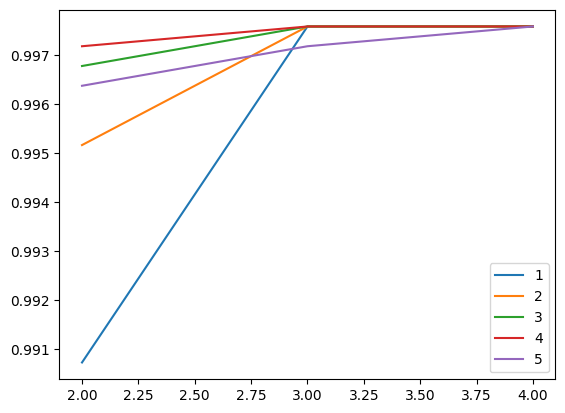

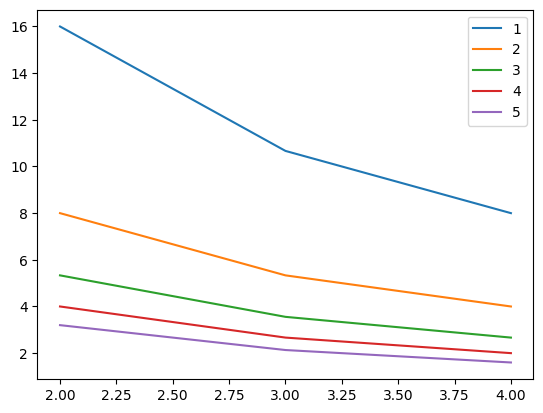

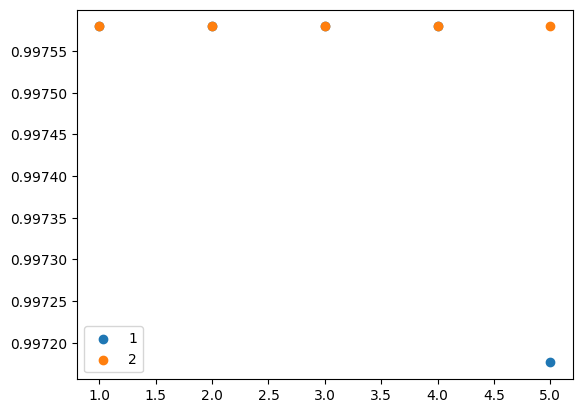

In [45]:
for redundancy in redundancies:
    plt.plot(bws[:3], val_accs[redundancy][:3])
plt.legend(redundancies)
plt.show()

for redundancy in redundancies:
    plt.plot(bws[:3], compressions[redundancy][:3])
plt.legend(redundancies)
plt.show()

i_s = [1,2]
for i in i_s:
    val_acc_bw_i = [val_accs[r][i] for r in redundancies]
    plt.scatter(redundancies, val_acc_bw_i)
plt.legend(i_s)
plt.show() 

In [46]:
# This is with the Weiner Filter based estimation
# redundancies = [1,2,3,4,5]
# bws = [2,3,4,8,16,32]
redundancies = [1,2,3,4,5]
bws = [2,3,4,8]

val_accs_naive = {}
compressions_naive = {}
for redundancy in redundancies:
    print(f'{redundancy = }')
    # set tff related params
    k_attn = int(96 * redundancy)
    l_attn = 8
    n_attn = 768
    tffs = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)

    val_accs_r = []
    compressions_r = []
    for bw in bws:
        print(f'{bw = }')
        model = VisionTransformer(config, args.img_size, zero_head=False, num_classes=num_classes)
        model.load_state_dict(torch.load(ckpt_path))
        model.eval()
        model.to(args.device)

        # set bit width related params
        maxq = torch.tensor(2**bw - 1)
        for name, param in model.named_parameters():
            if 'attn' in name:
                wmat = param.data
                if 'bias' in name:
                    wmat = wmat.view(n_attn,1)
                projs = torch.matmul(tffs, wmat)
                # quantize the projs
                xmax = projs.max()
                xmin = projs.min()
                scale = (xmax - xmin) / maxq
                zero = torch.round(-xmin / scale)
                projs_qntzd = quantize_qfna(projs, scale, zero, maxq) 
                # compute the weiner filter
                z = projs_qntzd.view(k_attn*l_attn, -1)
                Rxz = wmat @ z.T
                Rzz = z @ z.T
                wmat_est = Rxz @ torch.linalg.pinv(Rzz) @ z
                # param.data = wmat_est.squeeze()
                param.data = (tffs.view(-1,n_attn).T @ projs_qntzd.view(k_attn*l_attn, -1)).squeeze()

        val_acc = valid(args, model, writer=None, test_loader=test_loader, global_step=0)
        val_accs_r.append(val_acc)

        compression = 32/(redundancy*bw)
        compressions_r.append(compression)
    val_accs_naive[redundancy] = val_accs_r
    compressions_naive[redundancy] = compressions_r


redundancy = 1
bw = 2


2023-10-26 14:35:32,603 - train - INFO - ***** Running Validation *****
2023-10-26 14:35:32,604 - train - INFO -   Num steps = 155
2023-10-26 14:35:32,604 - train - INFO -   Batch size = 16
Validating... (loss=2.80377): 100%|| 155/155 [00:08<00:00, 19.30it/s]
2023-10-26 14:35:40,638 - train - INFO - 

2023-10-26 14:35:40,639 - train - INFO - Validation Results
2023-10-26 14:35:40,639 - train - INFO - Global Steps: 0
2023-10-26 14:35:40,640 - train - INFO - Valid Loss: 2.87577
2023-10-26 14:35:40,640 - train - INFO - Valid Accuracy: 0.11698


bw = 3


2023-10-26 14:35:45,262 - train - INFO - ***** Running Validation *****
2023-10-26 14:35:45,263 - train - INFO -   Num steps = 155
2023-10-26 14:35:45,264 - train - INFO -   Batch size = 16
Validating... (loss=0.02851): 100%|| 155/155 [00:08<00:00, 19.15it/s]
2023-10-26 14:35:53,360 - train - INFO - 

2023-10-26 14:35:53,361 - train - INFO - Validation Results
2023-10-26 14:35:53,361 - train - INFO - Global Steps: 0
2023-10-26 14:35:53,361 - train - INFO - Valid Loss: 0.07493
2023-10-26 14:35:53,362 - train - INFO - Valid Accuracy: 0.97701


bw = 4


2023-10-26 14:35:58,192 - train - INFO - ***** Running Validation *****
2023-10-26 14:35:58,194 - train - INFO -   Num steps = 155
2023-10-26 14:35:58,194 - train - INFO -   Batch size = 16
Validating... (loss=0.00162): 100%|| 155/155 [00:08<00:00, 19.26it/s]
2023-10-26 14:36:06,247 - train - INFO - 

2023-10-26 14:36:06,248 - train - INFO - Validation Results
2023-10-26 14:36:06,248 - train - INFO - Global Steps: 0
2023-10-26 14:36:06,249 - train - INFO - Valid Loss: 0.01524
2023-10-26 14:36:06,249 - train - INFO - Valid Accuracy: 0.99516


bw = 8


2023-10-26 14:36:11,740 - train - INFO - ***** Running Validation *****
2023-10-26 14:36:11,741 - train - INFO -   Num steps = 155
2023-10-26 14:36:11,742 - train - INFO -   Batch size = 16
Validating... (loss=0.00288): 100%|| 155/155 [00:08<00:00, 19.15it/s]
2023-10-26 14:36:19,839 - train - INFO - 

2023-10-26 14:36:19,839 - train - INFO - Validation Results
2023-10-26 14:36:19,840 - train - INFO - Global Steps: 0
2023-10-26 14:36:19,840 - train - INFO - Valid Loss: 0.01158
2023-10-26 14:36:19,841 - train - INFO - Valid Accuracy: 0.99758


redundancy = 2
bw = 2


2023-10-26 14:36:45,477 - train - INFO - ***** Running Validation *****
2023-10-26 14:36:45,479 - train - INFO -   Num steps = 155
2023-10-26 14:36:45,480 - train - INFO -   Batch size = 16
Validating... (loss=2.29553): 100%|| 155/155 [00:08<00:00, 19.23it/s]
2023-10-26 14:36:53,545 - train - INFO - 

2023-10-26 14:36:53,545 - train - INFO - Validation Results
2023-10-26 14:36:53,546 - train - INFO - Global Steps: 0
2023-10-26 14:36:53,546 - train - INFO - Valid Loss: 2.72814
2023-10-26 14:36:53,547 - train - INFO - Valid Accuracy: 0.12666


bw = 3


2023-10-26 14:37:21,892 - train - INFO - ***** Running Validation *****
2023-10-26 14:37:21,892 - train - INFO -   Num steps = 155
2023-10-26 14:37:21,893 - train - INFO -   Batch size = 16
Validating... (loss=0.01027): 100%|| 155/155 [00:08<00:00, 19.23it/s]
2023-10-26 14:37:29,955 - train - INFO - 

2023-10-26 14:37:29,956 - train - INFO - Validation Results
2023-10-26 14:37:29,956 - train - INFO - Global Steps: 0
2023-10-26 14:37:29,956 - train - INFO - Valid Loss: 0.02628
2023-10-26 14:37:29,957 - train - INFO - Valid Accuracy: 0.99193


bw = 4


2023-10-26 14:37:58,298 - train - INFO - ***** Running Validation *****
2023-10-26 14:37:58,300 - train - INFO -   Num steps = 155
2023-10-26 14:37:58,300 - train - INFO -   Batch size = 16
Validating... (loss=0.00180): 100%|| 155/155 [00:08<00:00, 19.30it/s]
2023-10-26 14:38:06,333 - train - INFO - 

2023-10-26 14:38:06,333 - train - INFO - Validation Results
2023-10-26 14:38:06,334 - train - INFO - Global Steps: 0
2023-10-26 14:38:06,334 - train - INFO - Valid Loss: 0.01284
2023-10-26 14:38:06,334 - train - INFO - Valid Accuracy: 0.99677


bw = 8


2023-10-26 14:38:36,687 - train - INFO - ***** Running Validation *****
2023-10-26 14:38:36,689 - train - INFO -   Num steps = 155
2023-10-26 14:38:36,689 - train - INFO -   Batch size = 16
Validating... (loss=0.00281): 100%|| 155/155 [00:08<00:00, 19.25it/s]
2023-10-26 14:38:44,744 - train - INFO - 

2023-10-26 14:38:44,745 - train - INFO - Validation Results
2023-10-26 14:38:44,745 - train - INFO - Global Steps: 0
2023-10-26 14:38:44,745 - train - INFO - Valid Loss: 0.01157
2023-10-26 14:38:44,746 - train - INFO - Valid Accuracy: 0.99758


redundancy = 3
bw = 2


2023-10-26 14:39:59,373 - train - INFO - ***** Running Validation *****
2023-10-26 14:39:59,374 - train - INFO -   Num steps = 155
2023-10-26 14:39:59,375 - train - INFO -   Batch size = 16
Validating... (loss=2.68325): 100%|| 155/155 [00:08<00:00, 19.25it/s]
2023-10-26 14:40:07,431 - train - INFO - 

2023-10-26 14:40:07,432 - train - INFO - Validation Results
2023-10-26 14:40:07,432 - train - INFO - Global Steps: 0
2023-10-26 14:40:07,433 - train - INFO - Valid Loss: 2.77971
2023-10-26 14:40:07,433 - train - INFO - Valid Accuracy: 0.13191


bw = 3


2023-10-26 14:41:25,677 - train - INFO - ***** Running Validation *****
2023-10-26 14:41:25,678 - train - INFO -   Num steps = 155
2023-10-26 14:41:25,678 - train - INFO -   Batch size = 16
Validating... (loss=0.02227): 100%|| 155/155 [00:08<00:00, 19.18it/s]
2023-10-26 14:41:33,761 - train - INFO - 

2023-10-26 14:41:33,762 - train - INFO - Validation Results
2023-10-26 14:41:33,762 - train - INFO - Global Steps: 0
2023-10-26 14:41:33,763 - train - INFO - Valid Loss: 0.02545
2023-10-26 14:41:33,763 - train - INFO - Valid Accuracy: 0.99113


bw = 4


2023-10-26 14:42:54,254 - train - INFO - ***** Running Validation *****
2023-10-26 14:42:54,256 - train - INFO -   Num steps = 155
2023-10-26 14:42:54,256 - train - INFO -   Batch size = 16
Validating... (loss=0.00195): 100%|| 155/155 [00:08<00:00, 19.19it/s]
2023-10-26 14:43:02,337 - train - INFO - 

2023-10-26 14:43:02,338 - train - INFO - Validation Results
2023-10-26 14:43:02,338 - train - INFO - Global Steps: 0
2023-10-26 14:43:02,339 - train - INFO - Valid Loss: 0.01370
2023-10-26 14:43:02,339 - train - INFO - Valid Accuracy: 0.99516


bw = 8


2023-10-26 14:44:26,359 - train - INFO - ***** Running Validation *****
2023-10-26 14:44:26,360 - train - INFO -   Num steps = 155
2023-10-26 14:44:26,361 - train - INFO -   Batch size = 16
Validating... (loss=0.00304): 100%|| 155/155 [00:08<00:00, 19.14it/s]
2023-10-26 14:44:34,463 - train - INFO - 

2023-10-26 14:44:34,464 - train - INFO - Validation Results
2023-10-26 14:44:34,464 - train - INFO - Global Steps: 0
2023-10-26 14:44:34,464 - train - INFO - Valid Loss: 0.01146
2023-10-26 14:44:34,465 - train - INFO - Valid Accuracy: 0.99758


redundancy = 4
bw = 2


2023-10-26 14:47:08,362 - train - INFO - ***** Running Validation *****
2023-10-26 14:47:08,364 - train - INFO -   Num steps = 155
2023-10-26 14:47:08,365 - train - INFO -   Batch size = 16
Validating... (loss=2.36278): 100%|| 155/155 [00:08<00:00, 19.19it/s]
2023-10-26 14:47:16,448 - train - INFO - 

2023-10-26 14:47:16,448 - train - INFO - Validation Results
2023-10-26 14:47:16,449 - train - INFO - Global Steps: 0
2023-10-26 14:47:16,449 - train - INFO - Valid Loss: 2.56963
2023-10-26 14:47:16,449 - train - INFO - Valid Accuracy: 0.18314


bw = 3


2023-10-26 14:49:58,909 - train - INFO - ***** Running Validation *****
2023-10-26 14:49:58,910 - train - INFO -   Num steps = 155
2023-10-26 14:49:58,911 - train - INFO -   Batch size = 16
Validating... (loss=0.01163): 100%|| 155/155 [00:08<00:00, 19.21it/s]
2023-10-26 14:50:06,984 - train - INFO - 

2023-10-26 14:50:06,985 - train - INFO - Validation Results
2023-10-26 14:50:06,985 - train - INFO - Global Steps: 0
2023-10-26 14:50:06,986 - train - INFO - Valid Loss: 0.01977
2023-10-26 14:50:06,986 - train - INFO - Valid Accuracy: 0.99355


bw = 4


2023-10-26 14:52:52,361 - train - INFO - ***** Running Validation *****
2023-10-26 14:52:52,363 - train - INFO -   Num steps = 155
2023-10-26 14:52:52,363 - train - INFO -   Batch size = 16
Validating... (loss=0.00324): 100%|| 155/155 [00:08<00:00, 19.22it/s]
2023-10-26 14:53:00,431 - train - INFO - 

2023-10-26 14:53:00,432 - train - INFO - Validation Results
2023-10-26 14:53:00,433 - train - INFO - Global Steps: 0
2023-10-26 14:53:00,433 - train - INFO - Valid Loss: 0.01394
2023-10-26 14:53:00,434 - train - INFO - Valid Accuracy: 0.99556


bw = 8


2023-10-26 14:55:54,863 - train - INFO - ***** Running Validation *****
2023-10-26 14:55:54,865 - train - INFO -   Num steps = 155
2023-10-26 14:55:54,865 - train - INFO -   Batch size = 16
Validating... (loss=0.00268): 100%|| 155/155 [00:08<00:00, 19.20it/s]
2023-10-26 14:56:02,943 - train - INFO - 

2023-10-26 14:56:02,943 - train - INFO - Validation Results
2023-10-26 14:56:02,944 - train - INFO - Global Steps: 0
2023-10-26 14:56:02,944 - train - INFO - Valid Loss: 0.01144
2023-10-26 14:56:02,945 - train - INFO - Valid Accuracy: 0.99758


redundancy = 5
bw = 2


2023-10-26 15:01:22,989 - train - INFO - ***** Running Validation *****
2023-10-26 15:01:22,993 - train - INFO -   Num steps = 155
2023-10-26 15:01:22,994 - train - INFO -   Batch size = 16
Validating... (loss=2.33421): 100%|| 155/155 [00:08<00:00, 18.57it/s]
2023-10-26 15:01:31,346 - train - INFO - 

2023-10-26 15:01:31,346 - train - INFO - Validation Results
2023-10-26 15:01:31,347 - train - INFO - Global Steps: 0
2023-10-26 15:01:31,347 - train - INFO - Valid Loss: 2.49715
2023-10-26 15:01:31,348 - train - INFO - Valid Accuracy: 0.14522


bw = 3


2023-10-26 15:06:59,009 - train - INFO - ***** Running Validation *****
2023-10-26 15:06:59,012 - train - INFO -   Num steps = 155
2023-10-26 15:06:59,012 - train - INFO -   Batch size = 16
Validating... (loss=0.00679): 100%|| 155/155 [00:08<00:00, 18.15it/s]
2023-10-26 15:07:07,555 - train - INFO - 

2023-10-26 15:07:07,556 - train - INFO - Validation Results
2023-10-26 15:07:07,556 - train - INFO - Global Steps: 0
2023-10-26 15:07:07,556 - train - INFO - Valid Loss: 0.02404
2023-10-26 15:07:07,557 - train - INFO - Valid Accuracy: 0.99193


bw = 4


2023-10-26 15:12:44,246 - train - INFO - ***** Running Validation *****
2023-10-26 15:12:44,247 - train - INFO -   Num steps = 155
2023-10-26 15:12:44,248 - train - INFO -   Batch size = 16
Validating... (loss=0.00346): 100%|| 155/155 [00:08<00:00, 18.16it/s]
2023-10-26 15:12:52,785 - train - INFO - 

2023-10-26 15:12:52,785 - train - INFO - Validation Results
2023-10-26 15:12:52,786 - train - INFO - Global Steps: 0
2023-10-26 15:12:52,786 - train - INFO - Valid Loss: 0.01368
2023-10-26 15:12:52,786 - train - INFO - Valid Accuracy: 0.99597


bw = 8


2023-10-26 15:18:46,647 - train - INFO - ***** Running Validation *****
2023-10-26 15:18:46,649 - train - INFO -   Num steps = 155
2023-10-26 15:18:46,649 - train - INFO -   Batch size = 16
Validating... (loss=0.00278): 100%|| 155/155 [00:08<00:00, 18.26it/s]
2023-10-26 15:18:55,138 - train - INFO - 

2023-10-26 15:18:55,139 - train - INFO - Validation Results
2023-10-26 15:18:55,139 - train - INFO - Global Steps: 0
2023-10-26 15:18:55,140 - train - INFO - Valid Loss: 0.01150
2023-10-26 15:18:55,140 - train - INFO - Valid Accuracy: 0.99758


In [22]:
# testing the Weiner filter
# wmat is x
# quantized projs are z
z = projs_qntzd.view(k_attn*l_attn, -1)
Rxz = wmat @ z.T
Rzz = z @ z.T
wmat_est = Rxz @ torch.linalg.pinv(Rzz) @ z

In [25]:
print(wmat_est.shape)
print(wmat_est.squeeze().shape)


torch.Size([768, 768])
torch.Size([768, 768])


In [23]:
print('wmat_est')
print(wmat_est)
print('wmat')
print(wmat)
print('naive')
wmat_naive = tffs.view(-1,n_attn).T @ projs_qntzd.view(k_attn*l_attn, -1)
print(wmat_naive)

# 
mse_weiner = F.mse_loss(wmat, wmat_est)
print(f'{mse_weiner = }')
mse_naive = F.mse_loss(wmat, wmat_naive)
print(f'{mse_naive = }')

wmat_est
tensor([[-0.0754,  0.0000, -0.1432,  ..., -0.0221,  0.0000,  0.0000],
        [ 0.0701,  0.0000,  0.0252,  ...,  0.1035,  0.0000,  0.0000],
        [ 0.0363,  0.0000, -0.1531,  ..., -0.0186,  0.0000,  0.0000],
        ...,
        [ 0.0137,  0.0000,  0.0926,  ..., -0.0392,  0.0000,  0.0000],
        [ 0.0546,  0.0000,  0.0163,  ..., -0.1063,  0.0000,  0.0000],
        [ 0.0256,  0.0000,  0.0482,  ..., -0.0450,  0.0000,  0.0000]],
       device='cuda:0')
wmat
tensor([[ 0.0174,  0.2517, -0.1405,  ...,  0.0091,  0.2832, -0.0861],
        [ 0.1056,  0.3413,  0.0517,  ...,  0.2695, -0.0123, -0.0827],
        [ 0.0319, -0.1285, -0.1943,  ...,  0.0244,  0.0331, -0.1172],
        ...,
        [ 0.0297,  0.0130,  0.1006,  ...,  0.0107, -0.0184, -0.1558],
        [ 0.0473,  0.0308, -0.0290,  ..., -0.0648,  0.0281, -0.2286],
        [ 0.0561,  0.1141, -0.0054,  ..., -0.0036,  0.0536,  0.0438]],
       device='cuda:0')
naive
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..

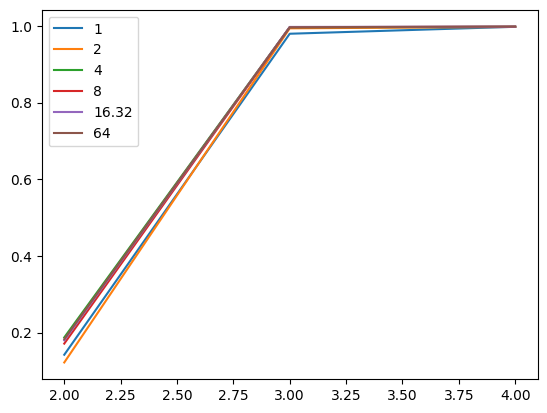

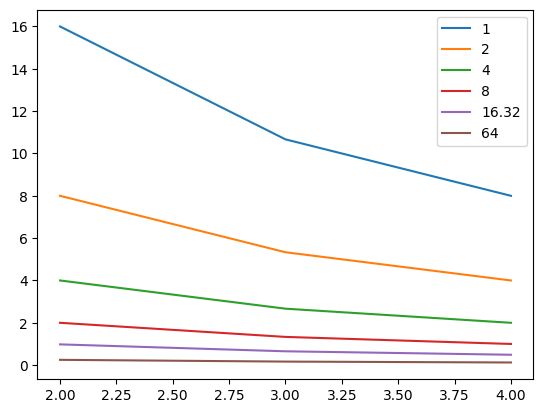

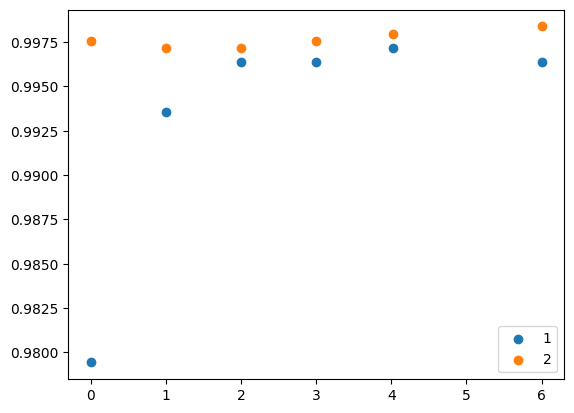

In [25]:
for redundancy in redundancies:
    plt.plot(bws[:3], val_accs[redundancy][:3])
plt.legend(redundancies)
plt.show()

for redundancy in redundancies:
    plt.plot(bws[:3], compressions[redundancy][:3])
plt.legend(redundancies)
plt.show()

i_s = [1,2]
for i in i_s:
    val_acc_bw_i = [val_accs[r][i] for r in redundancies]
    plt.scatter(np.log2(redundancies), val_acc_bw_i)
plt.legend(i_s)
plt.show()

In [26]:
wmat = wmat.view(n_attn, 1)
print(wmat.shape)
projs = torch.matmul(tffs, wmat)
print(projs.shape)
xmax = projs.max()
xmin = projs.min()
scale = (xmax - xmin) / maxq
zero = torch.round(-xmin / scale)
projs_qntzd = quantize_qfna(projs, scale, zero, maxq) 
print(projs_qntzd.shape)
new_data = tffs.view(-1,n_attn).T @ projs_qntzd.view(k_attn*l_attn, -1)
print(new_data.squeeze().shape)

torch.Size([768, 1])
torch.Size([768, 8, 1])
torch.Size([768, 8, 1])
torch.Size([768])


In [30]:
data = tffs.view(-1,n_attn).T @ projs_qntzd.view(-1,n_attn)
data.shape

torch.Size([768, 768])

In [34]:
for data, lbl in test_loader:
    data = data.to(device)
    embeds = model.transformer.embeddings(data[0].unsqueeze(0))
    print(embeds.shape)
    patch_embeds = model.transformer.embeddings.patch_embeddings(data[0])
    print(patch_embeds.shape)

    emb_wts = model.transformer.embeddings.patch_embeddings.weight.data.view(768,-1)
    model.transformer.embeddings.patch_embeddings.weight.data = emb_wts.view(768,3,16,16)
    new_embeds = model.transformer.embeddings(data[0].unsqueeze(0))
    print(emb_wts.shape)
    print(F.mse_loss(embeds, new_embeds))
    break

torch.Size([1, 197, 768])
torch.Size([768, 14, 14])
torch.Size([768, 768])
tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)


In [16]:
print(model.transformer.embeddings.patch_embeddings)
print(model.transformer.embeddings.patch_embeddings.weight.shape)
print(model.transformer.embeddings.patch_embeddings.bias.shape)

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
torch.Size([768, 3, 16, 16])
torch.Size([768])


In [62]:
print(model)
for name, param in model.named_parameters():
    print(name, param.shape)

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=Tru

In [72]:
len(model.transformer.encoder.layer[0].ffn_norm.weight.shape)
print(model.transformer.encoder.layer[0].ffn.fc1.weight.shape)
model.transformer.encoder.layer[0].ffn.fc1.weight.mean(dim=1, keepdim=True).shape
kk = model.transformer.encoder.layer[0].ffn.fc1.weight - model.transformer.encoder.layer[0].ffn.fc1.weight.mean(dim=1, keepdim=True)
kk.mean()

torch.Size([3072, 768])


tensor(8.3674e-11, device='cuda:0', grad_fn=<MeanBackward0>)

In [99]:
tffs = {}
k_attn = int(96 * redundancy)
l_attn = 8
n_attn = 768
tffs[n_attn] = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)

k_mlp = int(384 * redundancy)
l_mlp = 8
n_mlp = 3072
tffs[n_mlp] = construct_real_tff(k_mlp, l_mlp // 2, n_mlp // 2).to(args.device)

k_head = int(5 * redundancy)
l_head = 2
n_head = 10
tffs[n_head] = construct_real_tff(k_head, l_head // 2, n_head // 2).to(args.device)

wmat = model.transformer.encoder.layer[0].attn.query.weight.data
wmean = wmat.mean(dim=1, keepdim=True)
wmat = wmat - wmean
tff_n = wmat.shape[0]
projs = torch.matmul(tffs[tff_n], wmat)
num_frames = projs.shape[0]*projs.shape[1]
# quantize the projs
xmax = projs.max()
xmin = projs.min()
scale = (xmax - xmin) / maxq
zero = torch.round(-xmin / scale)
projs_qntzd = quantize_qfna(projs, scale, zero, maxq) 

z = projs_qntzd.view(num_frames, -1)
p = projs.view(num_frames, -1)
n = p-z
var_x = (wmat**2).mean(dim=1)
var_n = (n**2).mean(dim=1) # this can be optimized I guess
# wmat_est = (var_x/(var_x + var_n))*(tffs[tff_n].view(-1,tff_n).T @ z).squeeze()
wmat_naive = (tffs[tff_n].view(-1,tff_n).T @ z).squeeze()

Rxz = torch.diag(var_x) @ tffs[tff_n].view(-1,tff_n).T
Rzz = tffs[tff_n].view(-1,tff_n) @ torch.diag(var_x) @ tffs[tff_n].view(-1,tff_n).T + var_n
wmat_est2 = Rxz @ torch.linalg.pinv(Rzz) @ z
wmat_est2 = wmat_est.squeeze()

In [100]:
print(F.mse_loss(wmat_est, wmat))
print(F.mse_loss(wmat_naive, wmat))
print(F.mse_loss(wmat_est2, wmat))

tensor(0.0058, device='cuda:0')
tensor(0.0061, device='cuda:0')
tensor(0.0058, device='cuda:0')


In [37]:
print(768*3072*2)
print(768*768*4)

4718592
2359296


In [26]:
print(tffs.view(-1,n_attn).shape)
print(projs.view(-1,n_attn).shape)
print(wmat)
print(tffs.view(-1,n_attn).T @ projs_qntzd.view(-1,n_attn))
print('projs')
# print(projs)
# print(projs_qntzd)
tffs_qntz = tffs.view(-1,n_attn).T @ projs_qntzd.view(-1,n_attn)
mse = F.mse_loss(tffs_qntz, wmat)
print(f'{mse = }')

torch.Size([24576, 768])
torch.Size([24576, 768])
tensor([[-0.0129,  0.1042, -0.0019,  ...,  0.0456, -0.2268, -0.1550],
        [-0.1100, -0.2558, -0.1204,  ..., -0.0983, -0.0521,  0.2906],
        [-0.0483, -0.1248,  0.0144,  ..., -0.0147, -0.1421, -0.0169],
        ...,
        [ 0.0970,  0.0697, -0.0876,  ..., -0.0513, -0.1847, -0.0328],
        [-0.0626, -0.1369,  0.0075,  ...,  0.0609,  0.0814,  0.1998],
        [ 0.0776, -0.0431,  0.0912,  ...,  0.0103, -0.0486, -0.1427]],
       device='cuda:0')
tensor([[-2.0988e-02,  1.0401e-01,  2.3317e-04,  ...,  4.0344e-02,
         -2.2387e-01, -1.4948e-01],
        [-1.1264e-01, -2.5652e-01, -1.0984e-01,  ..., -9.6545e-02,
         -4.7573e-02,  2.8870e-01],
        [-5.6360e-02, -1.2636e-01,  1.6675e-02,  ..., -1.7930e-02,
         -1.4832e-01, -2.1397e-03],
        ...,
        [ 9.8019e-02,  7.2981e-02, -8.8432e-02,  ..., -6.1036e-02,
         -1.8832e-01, -3.4175e-02],
        [-5.9564e-02, -1.4381e-01,  5.7519e-03,  ...,  5.7240e-02,


In [13]:
# Quantization bit
for name, param in model.named_parameters():
    bw = 2
    maxq = torch.tensor(2**bw - 1)
    wmat = param.data

for looking_layer in [5]:
    # bits = [2,4,6,8,12,18,24,28, 32]
    # bits = [8,10,12]
    # redundancies = [1,4,8,16,32]
    bits = [2]
    redundancies = [1]
    plt.figure()
    for redundancy in redundancies:
        mses = []
        compressions = []
        for bw in bits:
            maxq = torch.tensor(2**bw - 1)
            wmat = model.transformer.encoder.layer[looking_layer].attn.key.weight.data
            k_attn = int(96 * redundancy)
            l_attn = 8
            n_attn = 768
            print(f'redundancy = {k_attn*l_attn/n_attn}')
            tffs = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)
            projs = torch.matmul(tffs, wmat)
            # quantize the projs
            xmax = projs.max()
            xmin = projs.min()
            scale = (xmax - xmin) / maxq
            zero = torch.round(-xmin / scale)
            projs_qntzd = quantize_qfna(projs, scale, zero, maxq) 
            mse = F.mse_loss(projs, projs_qntzd)
            mses.append(mse.item())

            compression = (32)//(bw*redundancy)
            compressions.append(compression)
            print(f'{bw = }, {mse = }, {redundancies = }')
        plt.semilogy(bits, mses)
    plt.legend([f'redundancy={i}x' for i in redundancies])
    plt.xlabel('number of bits')
    plt.ylabel('MSE')
    plt.title(f'layer {looking_layer}, MSE b/w the true weight, quantized weights')
    plt.grid()
    plt.savefig(f'./l{looking_layer}k')
    plt.close()

redundancy = 1.0
bw = 2, mse = tensor(0.0055, device='cuda:0'), redundancies = [1]


In [16]:
print(projs)
print('quantize_qfna')
print(projs_qntzd)

tensor([[[ 0.0374, -0.1320, -0.0572,  ..., -0.1327, -0.1225, -0.1874],
         [-0.0471, -0.0683,  0.0609,  ...,  0.1082,  0.0321, -0.0870],
         [ 0.0353,  0.1633,  0.0751,  ...,  0.0636, -0.0141,  0.1563],
         ...,
         [ 0.0939, -0.0422, -0.0873,  ...,  0.1134, -0.0979,  0.1152],
         [-0.0567, -0.1006, -0.0826,  ...,  0.0358, -0.0855,  0.0146],
         [ 0.0373,  0.1293,  0.0467,  ..., -0.0486, -0.0502,  0.0970]],

        [[-0.0795, -0.0548,  0.0145,  ...,  0.0806, -0.0950, -0.0070],
         [ 0.1856, -0.0286, -0.0224,  ..., -0.0666,  0.0139, -0.1065],
         [-0.0943, -0.2503, -0.0169,  ..., -0.0654,  0.0940,  0.0977],
         ...,
         [ 0.0252,  0.0780,  0.0261,  ..., -0.0120,  0.0988,  0.0457],
         [-0.0756, -0.0776,  0.0341,  ..., -0.0170,  0.0353,  0.1005],
         [-0.0081,  0.1360, -0.0046,  ...,  0.1070, -0.1370, -0.1372]],

        [[-0.0019, -0.1659, -0.1155,  ...,  0.0015,  0.0870, -0.1717],
         [ 0.0193, -0.0307, -0.1263,  ..., -0